🍫 Chocolate Products Analysis - Complete Pipeline
📥 Step 1: Collecting Chocolate Product Data...
Page 1: Collected 100 products. Total: 100
Page 2: Collected 100 products. Total: 200
Page 3: Collected 100 products. Total: 300
Page 4: Collected 100 products. Total: 400
Page 5: Collected 100 products. Total: 500
Page 6: Collected 100 products. Total: 600
Page 7: Collected 100 products. Total: 700
Page 8: Collected 100 products. Total: 800
Page 9: Collected 100 products. Total: 900
Page 10: Collected 100 products. Total: 1000
Page 11: Collected 100 products. Total: 1100
Page 12: Collected 100 products. Total: 1200
Page 13: Collected 100 products. Total: 1300
Page 14: Collected 100 products. Total: 1400
Page 15: Collected 99 products. Total: 1499
Page 16: Collected 100 products. Total: 1599
Page 17: Collected 100 products. Total: 1699
Page 18: Collected 100 products. Total: 1799
Page 19: Collected 100 products. Total: 1899
Page 20: Collected 100 products. Total: 1999
Page 21: Collected 100

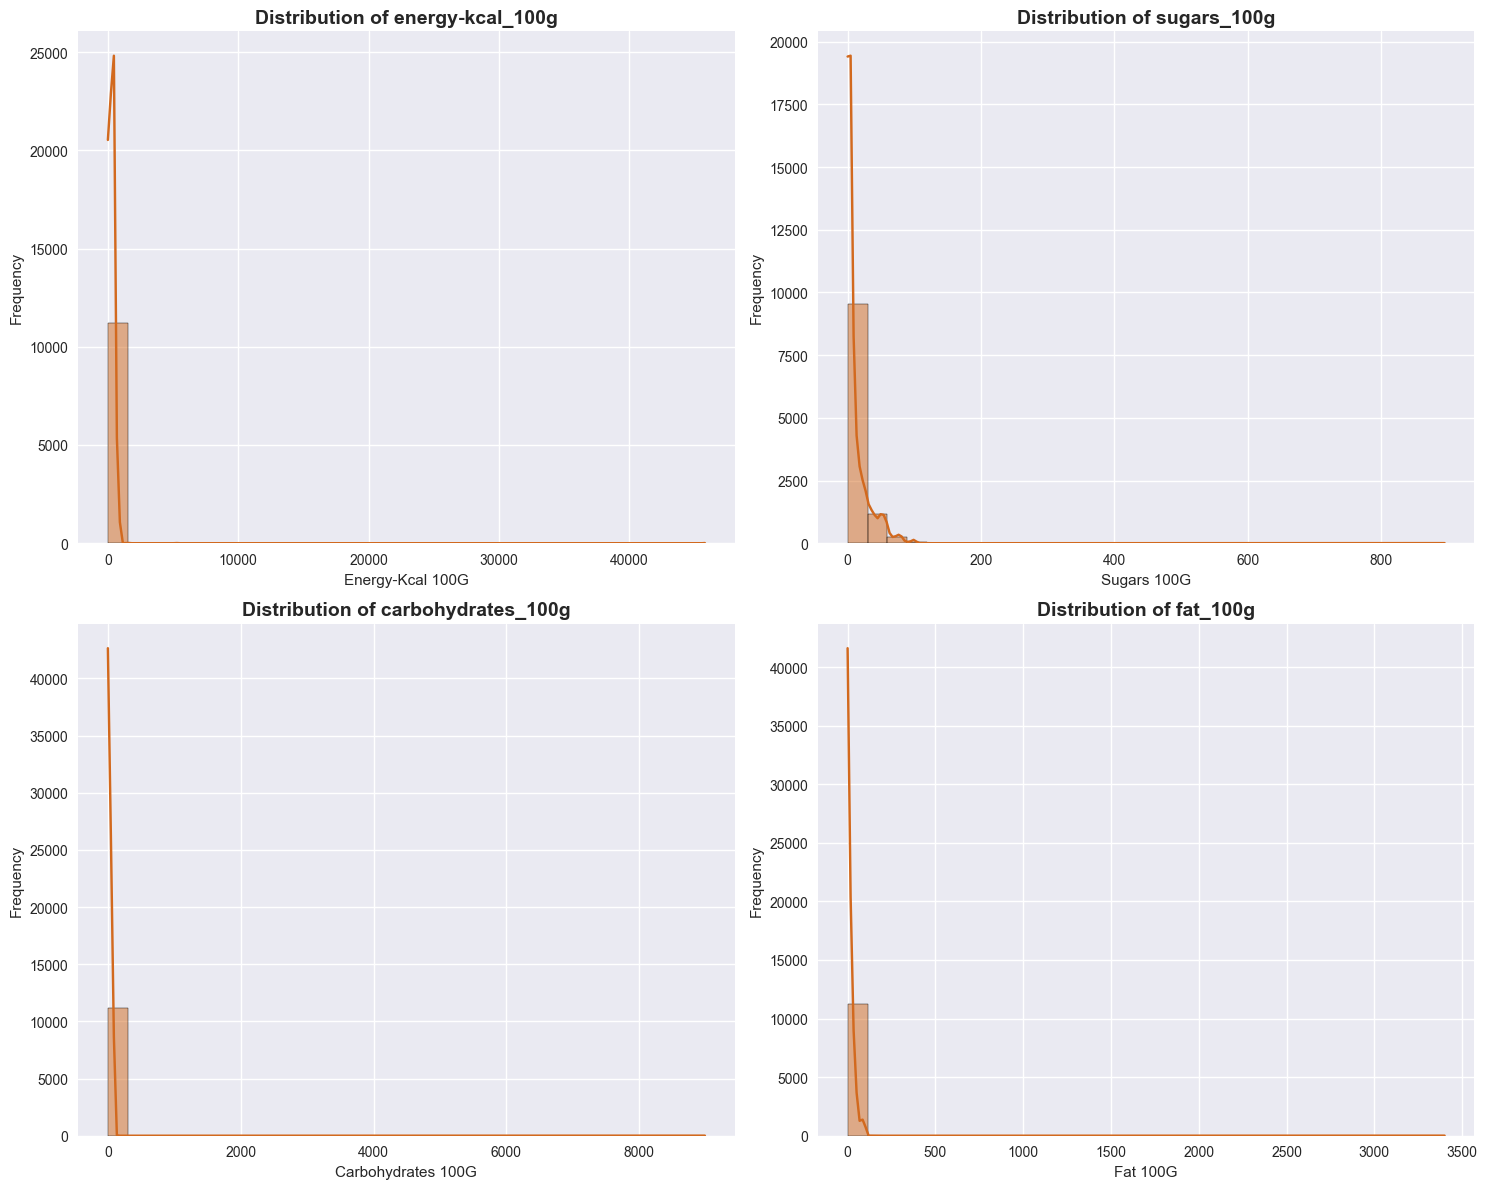

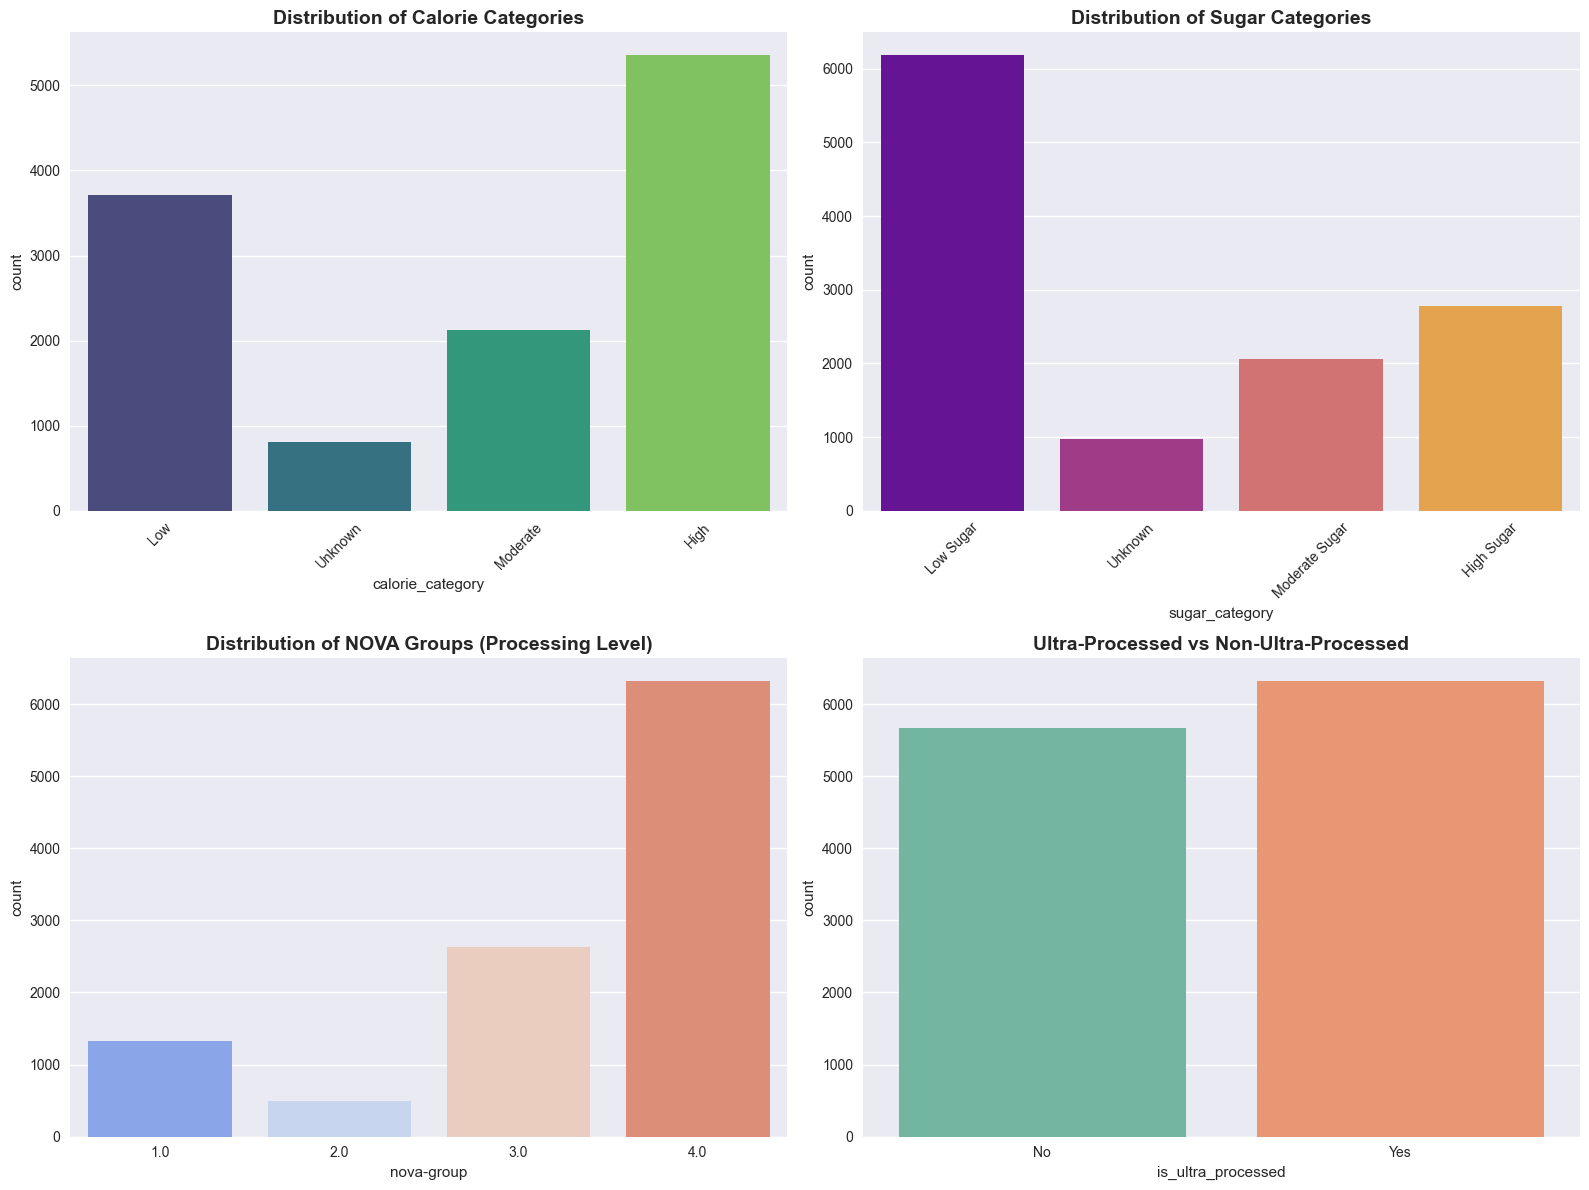

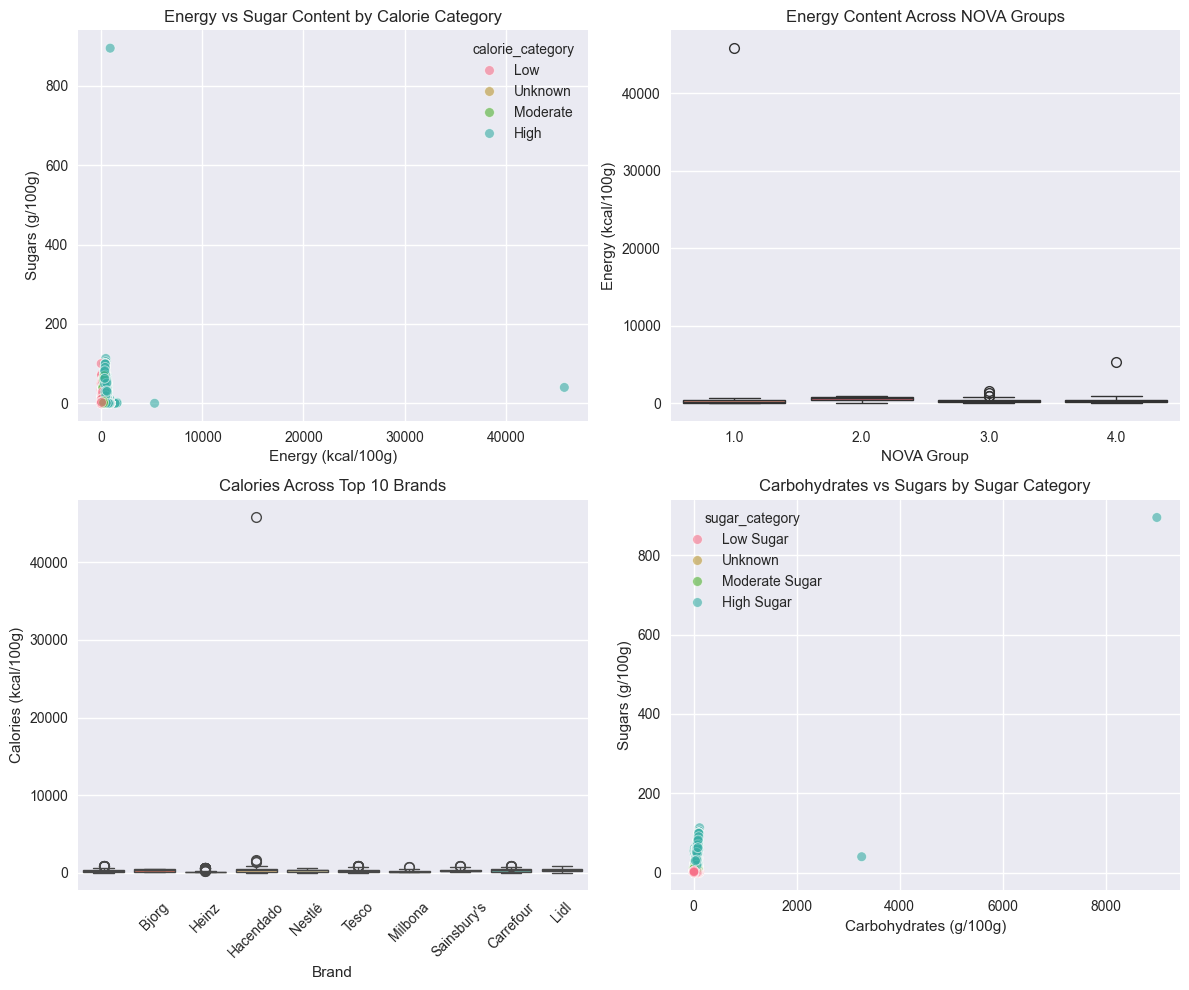

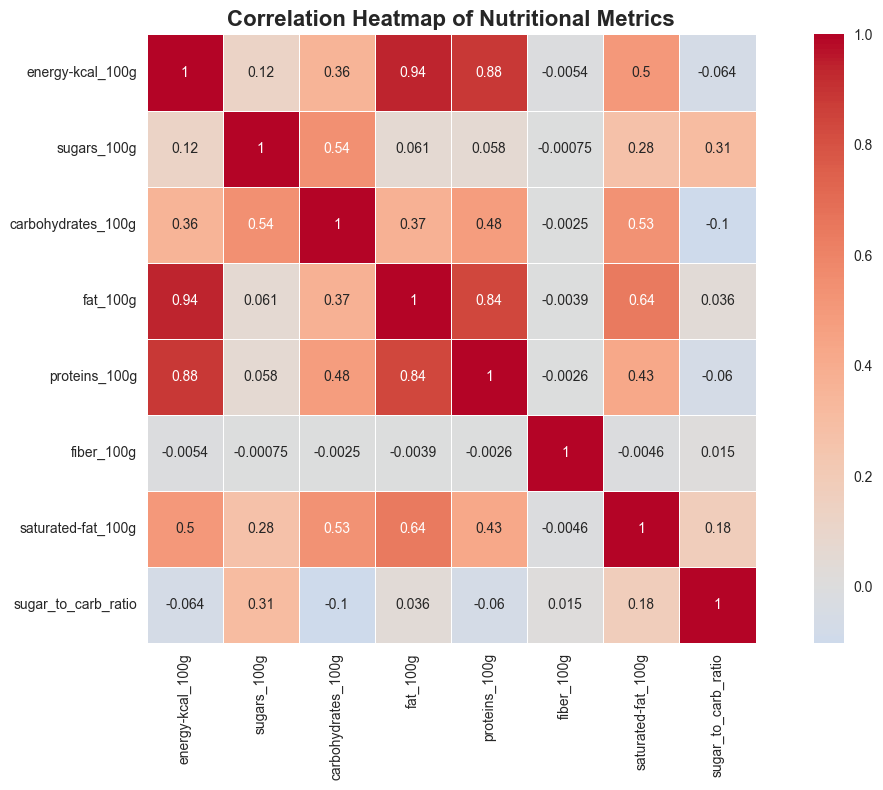


🔍 Advanced Analysis:
Products with sugar-to-carb ratio > 0.7: 4082
Ultra-processed products: 6327 (52.7%)
High calorie & high sugar products: 2268

🗃️ Step 5: SQL Database Setup and Data Insertion...
✅ Database and tables created successfully.
📤 Preparing data for SQL insertion...
Inserting product info...
Inserting nutrient info...
Inserting derived metrics...
✅ All data inserted successfully!

🔢 Step 6: SQL Queries and Analysis...

📑 PRODUCT_INFO TABLE QUERIES

📊 1. Count Products Per Brand
📈 Results: 3410
                                                                                                                brand  product_count
                                                                                                            Hacendado            911
                                                                                                                Tesco            274
                                                                                      

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🍫 Chocolate Products Analysis - Complete Pipeline")
print("=" * 60)

# =============================================
# STEP 1: DATASET COLLECTION
# =============================================

def collect_chocolate_data(max_items=12000, page_size=100):
    """Collect chocolate product data from OpenFoodFacts API"""
    print("📥 Step 1: Collecting Chocolate Product Data...")
    
    collected_data = []
    page = 1
    
    while len(collected_data) < max_items:
        url = f"https://world.openfoodfacts.org/api/v2/search?categories=chocolates&fields=code,product_name,brands,nutriments&page_size={page_size}&page={page}"
        
        try:
            response = requests.get(url, timeout=120)
            response.raise_for_status()
            data = response.json()
            products = data.get('products', [])
            
            if not products:
                print("No more products available.")
                break
                
            collected_data.extend(products)
            print(f"Page {page}: Collected {len(products)} products. Total: {len(collected_data)}")
            
            if len(products) > page_size:
                break
                
            page += 1
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data from page {page}: {e}")
            break
    
    # Trim to max_items
    collected_data = collected_data[:max_items]
    print(f"✅ Data collection complete! Total products: {len(collected_data)}")
    return collected_data

# Collect data
chocolate_data = collect_chocolate_data(12000, 100)

# Create initial DataFrame
df = pd.DataFrame(chocolate_data)
print(f"\nInitial DataFrame shape: {df.shape}")

# =============================================
# STEP 2: DATA EXPLORATION AND CLEANING
# =============================================

print("\n🧹 Step 2: Data Exploration and Cleaning...")

def explore_and_clean_data(df):
    """Explore and clean the chocolate dataset"""
    
    # Display basic info
    print("\n📊 Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Check for missing values
    print("\n🔍 Missing Values Analysis:")
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    
    missing_info = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percentage
    }).sort_values('Missing Count', ascending=False)
    
    print(missing_info[missing_info['Missing Count'] > 0])
    
    # Handle missing values
    print("\n🔄 Handling Missing Values...")
    
    # Drop columns with more than 50% missing values
    threshold = 0.5
    cols_to_drop = missing_info[missing_info['Missing Percentage'] > threshold * 100].index.tolist()
    
    if cols_to_drop:
        print(f"Dropping columns with >50% missing values: {cols_to_drop}")
        df_cleaned = df.drop(columns=cols_to_drop)
    else:
        df_cleaned = df.copy()
    
    # Handle remaining missing values
    for col in df_cleaned.columns:
        if df_cleaned[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_cleaned[col]):
                # Use median for numeric columns (less sensitive to outliers)
                median_val = df_cleaned[col].median()
                df_cleaned[col].fillna(median_val, inplace=True)
                print(f"Filled numeric column '{col}' with median: {median_val:.2f}")
            else:
                # Use mode for categorical/text columns
                mode_val = df_cleaned[col].mode()[0] if not df_cleaned[col].mode().empty else 'Unknown'
                df_cleaned[col].fillna(mode_val, inplace=True)
                print(f"Filled categorical column '{col}' with mode: {mode_val}")
    
    # Final missing value check
    remaining_missing = df_cleaned.isnull().sum().sum()
    print(f"\n✅ Remaining missing values after cleaning: {remaining_missing}")
    
    return df_cleaned

# Clean the data
df_cleaned = explore_and_clean_data(df)

# =============================================
# STEP 3: FEATURE ENGINEERING
# =============================================

print("\n🛠️ Step 3: Feature Engineering...")

def engineer_features(df_cleaned):
    """Create new features from the existing data"""
    
    # Extract and normalize nutriments
    print("📋 Extracting and normalizing nutriments...")
    
    # Required nutrient columns
    required_nutrients = [
        'energy-kcal_100g', 'energy-kj_100g', 'carbohydrates_100g', 
        'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'proteins_100g',
        'fiber_100g', 'salt_100g', 'sodium_100g', 'nova-group',
        'nutrition-score-fr_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g'
    ]
    
    # Create a copy for feature engineering
    df_featured = df_cleaned.copy()
    
    # Extract nutriments if they exist in nested structure
    if 'nutriments' in df_featured.columns:
        nutriments_df = pd.json_normalize(df_featured['nutriments'])
        
        # Filter for required nutrients that exist
        available_nutrients = [col for col in required_nutrients if col in nutriments_df.columns]
        nutriments_filtered = nutriments_df[available_nutrients]
        
        # Join back to main dataframe
        df_featured = pd.concat([df_featured.drop(columns=['nutriments']), nutriments_filtered], axis=1)
    
    # Create new features
    print("🎯 Creating derived features...")
    
    # 1. sugar_to_carb_ratio
    df_featured['sugar_to_carb_ratio'] = np.where(
        (df_featured['carbohydrates_100g'] > 0) & (df_featured['sugars_100g'].notna()),
        df_featured['sugars_100g'] / df_featured['carbohydrates_100g'],
        np.nan
    )
    
    # Handle infinite values
    df_featured['sugar_to_carb_ratio'] = df_featured['sugar_to_carb_ratio'].replace([np.inf, -np.inf], np.nan)
    
    # 2. calorie_category
    def classify_calories(kcal):
        if pd.isna(kcal):
            return 'Unknown'
        elif kcal < 150:
            return 'Low'
        elif kcal < 300:
            return 'Moderate'
        else:
            return 'High'
    
    df_featured['calorie_category'] = df_featured['energy-kcal_100g'].apply(classify_calories)
    
    # 3. sugar_category
    def classify_sugar(sugar):
        if pd.isna(sugar):
            return 'Unknown'
        elif sugar < 5:
            return 'Low Sugar'
        elif sugar < 15:
            return 'Moderate Sugar'
        else:
            return 'High Sugar'
    
    df_featured['sugar_category'] = df_featured['sugars_100g'].apply(classify_sugar)
    
    # 4. is_ultra_processed
    df_featured['is_ultra_processed'] = df_featured['nova-group'].apply(
        lambda x: 'Yes' if x == 4 else 'No'
    )
    
    print("✅ Feature engineering complete!")
    print(f"New features created: sugar_to_carb_ratio, calorie_category, sugar_category, is_ultra_processed")
    
    return df_featured

# Engineer features
df_final = engineer_features(df_cleaned)

# Display final dataframe info
print(f"\n📊 Final DataFrame Shape: {df_final.shape}")
print(f"Final Columns: {list(df_final.columns)}")

# =============================================
# STEP 4: EXPLORATORY DATA ANALYSIS (EDA)
# =============================================

print("\n📈 Step 4: Exploratory Data Analysis (EDA)...")

def perform_eda(df_final):
    """Perform comprehensive exploratory data analysis"""
    
    # Basic statistics
    print("\n📋 Basic Statistics:")
    print(df_final[['energy-kcal_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g']].describe())
    
    # Set up the plotting style
    plt.rcParams['figure.figsize'] = (12, 8)
    
    # 1. Distribution of Key Nutritional Values
    print("\n📊 Creating visualizations...")
    
    nutritional_cols = ['energy-kcal_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, col in enumerate(nutritional_cols):
        sns.histplot(df_final[col].dropna(), kde=True, ax=axes[i], color='chocolate', bins=30)
        axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel(col.replace('_', ' ').title())
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Categorical Distributions
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Calorie Category
    sns.countplot(data=df_final, x='calorie_category', ax=axes[0,0], palette='viridis')
    axes[0,0].set_title('Distribution of Calorie Categories', fontsize=14, fontweight='bold')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Sugar Category
    sns.countplot(data=df_final, x='sugar_category', ax=axes[0,1], palette='plasma')
    axes[0,1].set_title('Distribution of Sugar Categories', fontsize=14, fontweight='bold')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # NOVA Groups
    sns.countplot(data=df_final, x='nova-group', ax=axes[1,0], palette='coolwarm')
    axes[1,0].set_title('Distribution of NOVA Groups (Processing Level)', fontsize=14, fontweight='bold')
    
    # Ultra-processed vs Non-ultra-processed
    sns.countplot(data=df_final, x='is_ultra_processed', ax=axes[1,1], palette='Set2')
    axes[1,1].set_title('Ultra-Processed vs Non-Ultra-Processed', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Relationships between variables
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=df_final, x='energy-kcal_100g', y='sugars_100g', hue='calorie_category', alpha=0.6)
    plt.title('Energy vs Sugar Content by Calorie Category')
    plt.xlabel('Energy (kcal/100g)')
    plt.ylabel('Sugars (g/100g)')
    
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df_final, x='nova-group', y='energy-kcal_100g', palette='flare')
    plt.title('Energy Content Across NOVA Groups')
    plt.xlabel('NOVA Group')
    plt.ylabel('Energy (kcal/100g)')
    
    plt.subplot(2, 2, 3)
    # Top 10 brands by product count
    top_brands = df_final['brands'].value_counts().head(10).index
    df_top_brands = df_final[df_final['brands'].isin(top_brands)]
    sns.boxplot(data=df_top_brands, x='brands', y='energy-kcal_100g', palette='Spectral')
    plt.title('Calories Across Top 10 Brands')
    plt.xlabel('Brand')
    plt.ylabel('Calories (kcal/100g)')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=df_final, x='carbohydrates_100g', y='sugars_100g', hue='sugar_category', alpha=0.6)
    plt.title('Carbohydrates vs Sugars by Sugar Category')
    plt.xlabel('Carbohydrates (g/100g)')
    plt.ylabel('Sugars (g/100g)')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Correlation Heatmap
    numeric_cols = ['energy-kcal_100g', 'sugars_100g', 'carbohydrates_100g', 'fat_100g', 
                   'proteins_100g', 'fiber_100g', 'saturated-fat_100g', 'sugar_to_carb_ratio']
    
    # Filter for columns that exist
    available_numeric = [col for col in numeric_cols if col in df_final.columns]
    
    plt.figure(figsize=(12, 8))
    correlation_matrix = df_final[available_numeric].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Correlation Heatmap of Nutritional Metrics', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 5. Advanced Analysis
    print("\n🔍 Advanced Analysis:")
    
    # Sugar-to-carb ratio analysis
    high_ratio_products = df_final[df_final['sugar_to_carb_ratio'] > 0.7]
    print(f"Products with sugar-to-carb ratio > 0.7: {len(high_ratio_products)}")
    
    # Ultra-processed analysis
    ultra_processed = df_final[df_final['is_ultra_processed'] == 'Yes']
    print(f"Ultra-processed products: {len(ultra_processed)} ({len(ultra_processed)/len(df_final)*100:.1f}%)")
    
    # High calorie & high sugar products
    high_cal_sugar = df_final[(df_final['calorie_category'] == 'High') & 
                             (df_final['sugar_category'] == 'High Sugar')]
    print(f"High calorie & high sugar products: {len(high_cal_sugar)}")

# Perform EDA
perform_eda(df_final)

# =============================================
# STEP 5: SQL DATABASE SETUP AND DATA INSERTION
# =============================================

print("\n🗃️ Step 5: SQL Database Setup and Data Insertion...")

def setup_database_and_tables(engine):
    """Create database and tables"""
    try:
        with engine.connect() as conn:
            # Create database
            conn.execute(text("CREATE DATABASE IF NOT EXISTS ChocoCrunch_db"))
            conn.execute(text("USE ChocoCrunch_db"))
            
            # Create tables
            tables_sql = [
                """
                CREATE TABLE IF NOT EXISTS product_info (
                    product_code VARCHAR(255) PRIMARY KEY,
                    product_name TEXT,
                    brand TEXT
                )
                """,
                """
                CREATE TABLE IF NOT EXISTS nutrient_info (
                    product_code VARCHAR(255),
                    energy_kcal_value FLOAT,
                    energy_kj_value FLOAT,
                    carbohydrates_value FLOAT,
                    sugars_value FLOAT,
                    fat_value FLOAT,
                    saturated_fat_value FLOAT,
                    proteins_value FLOAT,
                    fiber_value FLOAT,
                    salt_value FLOAT,
                    sodium_value FLOAT,
                    fruits_vegetables_nuts_estimate_from_ingredients_100g FLOAT,
                    nutrition_score_fr INTEGER,
                    nova_group INTEGER,
                    FOREIGN KEY (product_code) REFERENCES product_info(product_code)
                )
                """,
                """
                CREATE TABLE IF NOT EXISTS derived_metrics (
                    product_code VARCHAR(255),
                    sugar_to_carb_ratio FLOAT,
                    calorie_category TEXT,
                    sugar_category TEXT,
                    is_ultra_processed TEXT,
                    FOREIGN KEY (product_code) REFERENCES product_info(product_code)
                )
                """
            ]
            
            for sql in tables_sql:
                conn.execute(text(sql))
            
            conn.commit()
            print("✅ Database and tables created successfully.")
            return True
            
    except SQLAlchemyError as e:
        print(f"❌ Error creating database/tables: {e}")
        return False

def insert_data_to_sql(engine, df_final):
    """Insert data from DataFrame to MySQL tables"""
    try:
        # Prepare DataFrames for each table
        print("📤 Preparing data for SQL insertion...")
        
        # Product Info
        df_product = df_final[['code', 'product_name', 'brands']].rename(columns={
            'code': 'product_code',
            'brands': 'brand'
        })
        
        # Nutrient Info
        nutrient_mapping = {
            'code': 'product_code',
            'energy-kcal_100g': 'energy_kcal_value',
            'energy-kj_100g': 'energy_kj_value',
            'carbohydrates_100g': 'carbohydrates_value',
            'sugars_100g': 'sugars_value',
            'fat_100g': 'fat_value',
            'saturated-fat_100g': 'saturated_fat_value',
            'proteins_100g': 'proteins_value',
            'fiber_100g': 'fiber_value',
            'salt_100g': 'salt_value',
            'sodium_100g': 'sodium_value',
            'fruits-vegetables-nuts-estimate-from-ingredients_100g': 'fruits_vegetables_nuts_estimate_from_ingredients_100g',
            'nutrition-score-fr_100g': 'nutrition_score_fr',
            'nova-group': 'nova_group'
        }
        
        # Filter for columns that exist
        available_cols = {k: v for k, v in nutrient_mapping.items() if k in df_final.columns}
        df_nutrient = df_final[list(available_cols.keys())].rename(columns=available_cols)
        
        # Derived Metrics
        df_derived = df_final[['code', 'sugar_to_carb_ratio', 'calorie_category', 
                              'sugar_category', 'is_ultra_processed']].rename(columns={
            'code': 'product_code'
        })
        
        # Insert data using pandas to_sql (more efficient than row-by-row)
        print("Inserting product info...")
        df_product.to_sql('product_info', con=engine, if_exists='append', index=False, chunksize=12000)
        
        print("Inserting nutrient info...")
        df_nutrient.to_sql('nutrient_info', con=engine, if_exists='append', index=False, chunksize=12000)
        
        print("Inserting derived metrics...")
        df_derived.to_sql('derived_metrics', con=engine, if_exists='append', index=False, chunksize=12000)
        
        print("✅ All data inserted successfully!")
        return True
        
    except Exception as e:
        print(f"❌ Error inserting data: {e}")
        return False

# Database connection details (Update these with your credentials)
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': 'nsnk'  # Replace with your actual password
}

try:
    # Create engine and setup database
    engine = create_engine(f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/")
    
    if setup_database_and_tables(engine):
        # Reconnect to the specific database
        engine = create_engine(f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/ChocoCrunch_db")
        
        # Insert data
        insert_data_to_sql(engine, df_final)
    
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Skipping SQL operations. Data is available in pandas DataFrame.")

# =============================================
# STEP 6: SQL QUERIES AND ANALYSIS
# =============================================

print("\n🔢 Step 6: SQL Queries and Analysis...")

def execute_sql_queries(engine):
    """Execute comprehensive SQL queries on the chocolate database"""
    
    def run_query(query, description):
        """Helper function to run and display query results"""
        print(f"\n{'='*70}")
        print(f"📊 {description}")
        print(f"{'='*70}")
        
        try:
            with engine.connect() as conn:
                result = conn.execute(text(query))
                
                if result.returns_rows:
                    df = pd.DataFrame(result.fetchall(), columns=result.keys())
                    if not df.empty:
                        print(f"📈 Results: {len(df)}")
                        print(df.to_string(index=False))
                    else:
                        print("No results found.")
                else:
                    print("✅ Query executed successfully")
                    
        except Exception as e:
            print(f"❌ Error: {e}")

    # ==================== PRODUCT_INFO QUERIES ====================
    print("\n📑 PRODUCT_INFO TABLE QUERIES")
    
    queries = [
        # Product Info Queries
        ("""
        SELECT 
    brand,
    COUNT(*) as product_count
FROM product_info 
WHERE brand IS NOT NULL AND brand != ''
GROUP BY brand
ORDER BY product_count DESC;
        """, "1. Count Products Per Brand"),
        
        ("""
       SELECT 
    brand,
    COUNT(DISTINCT product_code) as unique_product_count,
    COUNT(DISTINCT product_name) as unique_name_count
FROM product_info 
WHERE brand IS NOT NULL AND brand != ''
GROUP BY brand
ORDER BY unique_product_count DESC;
        """, "2. Count Unique Products Per Brand"),
        
        ("""
        SELECT 
            brand,
            COUNT(*) as product_count
        FROM product_info 
        WHERE brand IS NOT NULL AND brand != ''
        GROUP BY brand
        ORDER BY product_count DESC
        LIMIT 5;
        """, "3. Top 5 Brands by Product Count"),
        
        ("""
        SELECT 
            COUNT(*) as products_with_missing_names
        FROM product_info 
        WHERE product_name IS NULL 
           OR product_name = '' 
           OR LENGTH(TRIM(product_name)) = 0;
        """, "4. Products with Missing Product Name"),

        ("""
        SELECT 
            COUNT(DISTINCT brand) as unique_brands_count
        FROM product_info 
        WHERE brand IS NOT NULL AND brand != '';
        """, "5. Number of Unique Brands"),
        
        ("""
        SELECT 
            product_code,
            product_name,
            brand
        FROM product_info 
        WHERE product_code LIKE '3%'
        LIMIT 10;
        """, "6. Products with Code Starting With '3' (Sample)"),
        
        ("""
        SELECT 
            COUNT(*) as total_products,
            COUNT(DISTINCT brand) as total_brands,
            SUM(CASE WHEN product_name IS NULL OR product_name = '' THEN 1 ELSE 0 END) as missing_names,
            SUM(CASE WHEN brand IS NULL OR brand = '' THEN 1 ELSE 0 END) as missing_brands
        FROM product_info;
        """, "7. Overall Summary Statistics"),

        ( """
        SELECT 
            brand,
            COUNT(*) as total_products,
            SUM(CASE WHEN product_name IS NULL OR product_name = '' THEN 1 ELSE 0 END) as missing_names,
            ROUND((SUM(CASE WHEN product_name IS NULL OR product_name = '' THEN 1 ELSE 0 END) * 100.0 / COUNT(*)), 2) as missing_percentage
        FROM product_info 
        WHERE brand IS NOT NULL AND brand != ''
        GROUP BY brand
        HAVING missing_names > 0
        ORDER BY missing_names DESC;
        """, "8. Brands With Missing Product Names"),

        
        
        # ==================== NUTRIENT_INFO QUERIES ====================
        ("\n📑 NUTRIENT_INFO TABLE QUERIES", "Section Header"),
        
        ("""
        SELECT 
            pi.product_code,
            pi.product_name,
            pi.brand,
            ni.energy_kcal_value
        FROM nutrient_info ni
        JOIN product_info pi ON ni.product_code = pi.product_code
        WHERE ni.energy_kcal_value IS NOT NULL
        ORDER BY ni.energy_kcal_value DESC
        LIMIT 10;
        """, "9. Top 10 Products with Highest Energy (kcal)"),
        
        ("""
        SELECT 
            nova_group,
            ROUND(AVG(sugars_value), 2) as avg_sugars,
            COUNT(*) as product_count
        FROM nutrient_info
        WHERE nova_group IS NOT NULL AND sugars_value IS NOT NULL
        GROUP BY nova_group
        ORDER BY nova_group;
        """, "10. Average Sugars Value per NOVA Group"),
        
        ("""
        SELECT COUNT(*) as high_fat_products
        FROM nutrient_info
        WHERE fat_value > 20;
        """, "11. Count Products with Fat Value > 20g"),
        
        ("""
        SELECT 
            ROUND(AVG(carbohydrates_value), 2) as avg_carbohydrates,
            ROUND(MIN(carbohydrates_value), 2) as min_carbohydrates,
            ROUND(MAX(carbohydrates_value), 2) as max_carbohydrates,
            ROUND(STD(carbohydrates_value), 2) as std_carbohydrates
        FROM nutrient_info
        WHERE carbohydrates_value IS NOT NULL;
        """, "12. Carbohydrates Value Statistics"),
        
        ("""
        SELECT COUNT(*) as high_sodium_products
        FROM nutrient_info
        WHERE sodium_value > 1;
        """, "13. Products with Sodium Value > 1g"),
        
        ("""
        SELECT COUNT(*) as products_with_fruits_veg_nuts
        FROM nutrient_info
        WHERE fruits_vegetables_nuts_estimate_from_ingredients_100g > 0;
        """, "14. Products with Non-zero Fruits/Vegetables/Nuts Content"),
        
        ("""
        SELECT COUNT(*) as very_high_calorie_products
        FROM nutrient_info
        WHERE energy_kcal_value > 500;
        """, "15. Products with Energy > 500 kcal"),
        
        # ==================== DERIVED_METRICS QUERIES ====================
        ("\n📑 DERIVED_METRICS TABLE QUERIES", "Section Header"),
        
        ("""
        SELECT 
            calorie_category,
            COUNT(*) as product_count,
            ROUND((COUNT(*) * 100.0 / (SELECT COUNT(*) FROM derived_metrics)), 2) as percentage
        FROM derived_metrics
        WHERE calorie_category IS NOT NULL
        GROUP BY calorie_category
        ORDER BY product_count DESC;
        """, "16. Count Products Per Calorie Category"),
        
        ("""
        SELECT COUNT(*) as high_sugar_count
        FROM derived_metrics
        WHERE sugar_category = 'High Sugar';
        """, "17. Count of High Sugar Products"),
        
        ("""
        SELECT 
            ROUND(AVG(sugar_to_carb_ratio), 3) as avg_sugar_carb_ratio
        FROM derived_metrics
        WHERE calorie_category = 'High' 
          AND sugar_to_carb_ratio IS NOT NULL;
        """, "18. Average Sugar-to-Carb Ratio for High Calorie Products"),
        
        ("""
        SELECT COUNT(*) as high_calorie_high_sugar_count
        FROM derived_metrics
        WHERE calorie_category = 'High' 
          AND sugar_category = 'High Sugar';
        """, "19. Products that are Both High Calorie and High Sugar"),
        
        ("""
        SELECT 
            is_ultra_processed,
            COUNT(*) as product_count,
            ROUND((COUNT(*) * 100.0 / (SELECT COUNT(*) FROM derived_metrics)), 2) as percentage
        FROM derived_metrics
        WHERE is_ultra_processed IS NOT NULL
        GROUP BY is_ultra_processed;
        """, "20. Number of Ultra-Processed Products"),
        
        ("""
        SELECT COUNT(*) as high_sugar_carb_ratio_count
        FROM derived_metrics
        WHERE sugar_to_carb_ratio > 0.7;
        """, "21. Products with Sugar-to-Carb Ratio > 0.7"),
        
        ("""
        SELECT 
            calorie_category,
            ROUND(AVG(sugar_to_carb_ratio), 3) as avg_sugar_carb_ratio,
            COUNT(*) as product_count
        FROM derived_metrics
        WHERE calorie_category IS NOT NULL 
          AND sugar_to_carb_ratio IS NOT NULL
        GROUP BY calorie_category
        ORDER BY avg_sugar_carb_ratio DESC;
        """, "22. Average Sugar-to-Carb Ratio per Calorie Category"),
        
        # ==================== JOIN QUERIES ====================
        ("\n🔗 JOIN QUERY ANALYSIS", "Section Header"),
        
        ("""
        SELECT 
            pi.brand,
            COUNT(*) as high_calorie_count
        FROM derived_metrics dm
        JOIN product_info pi ON dm.product_code = pi.product_code
        WHERE dm.calorie_category = 'High'
          AND pi.brand IS NOT NULL
        GROUP BY pi.brand
        ORDER BY high_calorie_count DESC
        LIMIT 5;
        """, "23. Top 5 Brands with Most High Calorie Products"),
        
        ("""
        SELECT 
            dm.calorie_category,
            ROUND(AVG(ni.energy_kcal_value), 2) as avg_energy_kcal,
            COUNT(*) as product_count
        FROM derived_metrics dm
        JOIN nutrient_info ni ON dm.product_code = ni.product_code
        WHERE dm.calorie_category IS NOT NULL 
          AND ni.energy_kcal_value IS NOT NULL
        GROUP BY dm.calorie_category
        ORDER BY avg_energy_kcal DESC;
        """, "24. Average Energy (kcal) for Each Calorie Category"),
        
        ("""
        SELECT 
            pi.brand,
            COUNT(*) as ultra_processed_count
        FROM derived_metrics dm
        JOIN product_info pi ON dm.product_code = pi.product_code
        WHERE dm.is_ultra_processed = 'Yes'
          AND pi.brand IS NOT NULL
        GROUP BY pi.brand
        ORDER BY ultra_processed_count DESC;
        """, "25. Count of Ultra-Processed Products per Brand"),
        
        ("""
        SELECT 
            pi.brand,
            pi.product_name,
            ni.energy_kcal_value,
            ni.sugars_value,
            dm.sugar_to_carb_ratio
        FROM derived_metrics dm
        JOIN product_info pi ON dm.product_code = pi.product_code
        JOIN nutrient_info ni ON dm.product_code = ni.product_code
        WHERE dm.calorie_category = 'High' 
          AND dm.sugar_category = 'High Sugar'
        ORDER BY ni.sugars_value DESC
        LIMIT 10;
        """, "26. High Sugar & High Calorie Products with Brand Details"),
        
        ("""
        SELECT 
            pi.brand,
            COUNT(*) as product_count,
            ROUND(AVG(ni.sugars_value), 2) as avg_sugar_content
        FROM derived_metrics dm
        JOIN product_info pi ON dm.product_code = pi.product_code
        JOIN nutrient_info ni ON dm.product_code = ni.product_code
        WHERE dm.is_ultra_processed = 'Yes'
          AND pi.brand IS NOT NULL
          AND ni.sugars_value IS NOT NULL
        GROUP BY pi.brand
        HAVING product_count >= 3
        ORDER BY avg_sugar_content DESC
        LIMIT 10;
        """, "27. Average Sugar Content per Brand (Ultra-Processed Only)"),
        
        ("""
        SELECT 
            dm.calorie_category,
            COUNT(*) as total_products,
            SUM(CASE WHEN ni.fruits_vegetables_nuts_estimate_from_ingredients_100g > 0 THEN 1 ELSE 0 END) as with_fruits_veg_nuts,
            ROUND((SUM(CASE WHEN ni.fruits_vegetables_nuts_estimate_from_ingredients_100g > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)), 2) as percentage_with_fruits_veg_nuts
        FROM derived_metrics dm
        JOIN nutrient_info ni ON dm.product_code = ni.product_code
        WHERE dm.calorie_category IS NOT NULL
        GROUP BY dm.calorie_category
        ORDER BY percentage_with_fruits_veg_nuts DESC;
        """, "28. Fruits/Vegetables/Nuts Content by Calorie Category"),
        
        ("""
        SELECT 
            pi.brand,
            pi.product_name,
            dm.sugar_to_carb_ratio,
            dm.calorie_category,
            dm.sugar_category,
            ni.sugars_value,
            ni.carbohydrates_value
        FROM derived_metrics dm
        JOIN product_info pi ON dm.product_code = pi.product_code
        JOIN nutrient_info ni ON dm.product_code = ni.product_code
        WHERE dm.sugar_to_carb_ratio IS NOT NULL
        ORDER BY dm.sugar_to_carb_ratio DESC
        LIMIT 5;
        """, "29. Top 5 Products by Sugar-to-Carb Ratio")
    ]
    
    # Execute all queries
    for query, description in queries:
        if "Section Header" in description:
            print(description.replace("Section Header", ""))
        else:
            run_query(query, description)
    
    print(f"\n{'='*70}")
    print("✅ All SQL queries executed successfully!")
    print(f"{'='*70}")

# Execute SQL queries if database connection is available
try:
    if 'engine' in locals():
        execute_sql_queries(engine)
        engine.dispose()
except Exception as e:
    print(f"❌ SQL queries execution failed: {e}")

# =============================================
# FINAL SUMMARY
# =============================================

print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"📊 Total Products Analyzed: {len(df_final)}")
print(f"🛠️ Features Engineered: 4 new columns")
print(f"📈 Visualizations Created: Multiple charts and plots")
print(f"🗃️ Database Tables: 3 tables created and populated")
print(f"🔍 SQL Queries Executed: 29 analytical queries")
print("\n📋 Key Analysis Performed:")
print("  • Nutritional distribution analysis")
print("  • Product categorization by calories and sugar")
print("  • Ultra-processed food identification")
print("  • Brand-wise nutritional comparison")
print("  • Correlation analysis between nutrients")
print("  • SQL-based business intelligence queries")

# Save cleaned data to CSV for future use
df_final.to_csv('chocolate_products_analysis.csv', index=False)
print(f"\n💾 Data saved to 'chocolate_products_analysis.csv'")